# Pattern matching


We will start in the same way as the last notebook started  - by downloading/importing the packages needed and importing the .csv file(s) needed. In this case, we only need the .csv file that has the matched abstracts as we are specifically looking at person-first and identity-first patterns that are "about" autism (or ASD, Asperger's syndrome, etc.). 

We could use the same basic approach to look at person-first and identity-first language for other conditions for which there are good noun and adjective forms of the words (diabetes? obesity? cancer? something else?). Doing that would mean using the .csv file with all of the abstracts or potentially creating and entirely new file of abstracts matched to another condition of interest. However, that lies outside the scope of this research, so I will not address it further here. 

## Get ready 

As always, we start with a couple of code cells that load up and nickname some useful packages, then check file locations, then import files and check them. 

In [1]:
%%capture

# installing necessary pdf conversion packages via pip
# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output. 
!pip install nltk
!pip install spacy -q
!python -m spacy download en_core_web_lg -q


In [2]:
%%capture

import os                         # os is a module for navigating your machine (e.g., file directories).
import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions
from nltk import sent_tokenize  
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics

#import codecs
import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import string 
import spacy 
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 1500000 #or any large value, as long as you don't run out of RAM

import math

In [3]:
print(os.listdir("..\\output")  )      

['all_abstracts_no_null_texts.csv', 'matched_abstracts_no_null_texts.csv', 'most_frequent_comparison.csv']


## Import

Having checked the contents of the output folder and seen the files we expected to see, we can now import the specific file of interest for this step of the analysis.

In [4]:
matched_texts = pd.read_csv('..\\output\\matched_abstracts_no_null_texts.csv')    # one for just those that match the keyword
len(matched_texts)                                                                # check the length 

906

## Cleaning phase

The first step of pattern matching is to prepare the data by sentence tokenising the text. Like word tokens, sentence tokens become the unit for analysisis. As a trivial example, sentence tokenisation would turn a short text such as 


''' The cat named Cat is one of five cats. Honestly, I wonder why I have so many cats.
''' 

into a list of sentence tokens like

''' [[The cat named Cat is one of five cats.]

[Honestly, I wonder why I have so many cats.]]

''' 

An important difference is that the punctuation within the sentences that contributes to its structured and meaning (e.g. the comma and the full stops) are retained. This punctuation, like the capitalisation at the start of the sentences or for the poper nouns, is also retained as it helps the sentence-tokenisation process identify the words within the sentence correctly for their parts of speech (e.g. which of the words are nouns, verbs, etc. ). 



The sentence tokens are then put on individual rows, filtered to retain only those that contain one or more of the keywords of interest, and then filtered to ensure that there are no empty rows or duplicates. 

In [5]:
sentences  = [sent_tokenize(abstract) for abstract in matched_texts['Text'] ] # tokenize the text column and store as a list
matched_texts['Sentence'] = sentences                                   # copy that list back into df as a new column
sentence_per_row = matched_texts.explode('Sentence')                    # explode column in new df with 1 row/sentence token
len(sentence_per_row)                                                   # check the length of new df


13444

In [6]:
sentence_per_row                                                    # have a look. For the first two rows, 
                                                                    # 'Text' should be same, but 'Sentence' should not

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes.
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) the shift of the double bond from C8 9to C7 8(3ÃÂ§ sterol D 8 D7isomerase/EBP E.C.
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,5.3.3.5) and the removal of the double bond at C7 8(D7 sterol reduc tase/DHCR7 E.C.
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,1.3.1.21).
0,59,Genetic defects in sterol metabolism,S60.,F. MoebiusInstitute for Biochemical Pharmacology University of Innsbruck Innsbruck AustriaFabian.M,Genetic defects in sterol metabolizing enzymes have recently emerged asimportant causes of dysmorphogenetic syndromes. They affect enzymesrequired for the removal of methyl groups at C4(NSHDL) th...,2001.0,Fabian.Moebius@uibk.ac.at,NaN,NaN,Missense and nonsense mutations in NSHDL on Xq28 cause X chromosomal dominant CHILD syndrome (congenitalhemidysplasia with ichthyosiform erythroderma and limb defects MIM308050) a rare inborn dis...
...,...,...,...,...,...,...,...,...,...,...
905,2158,NaN,NaN,NaN,P0833Screening for ARX gene mutations is indicated for males problems. The study of this disorder has intensiÜed because with mental retardation associated with West syndrome and/or incidence i...,2004.0,NaN,NaN,NaN,This duplication patients 49 returned with completed metabolic work up.
905,2158,NaN,NaN,NaN,P0833Screening for ARX gene mutations is indicated for males problems. The study of this disorder has intensiÜed because with mental retardation associated with West syndrome and/or incidence i...,2004.0,NaN,NaN,NaN,In this group leads to an expansion of a polyalanine tract in the ARX protein.
905,2158,NaN,NaN,NaN,P0833Screening for ARX gene mutations is indicated for males problems. The study of this disorder has intensiÜed because with mental retardation associated with West syndrome and/or incidence i...,2004.0,NaN,NaN,NaN,"of 49 patients 18 had a diagnosis of autism and 31 of PDD, only one The ARX gene was screened for mutations in Üve males with mental patient was female, average age was 5.4 years."
905,2158,NaN,NaN,NaN,P0833Screening for ARX gene mutations is indicated for males problems. The study of this disorder has intensiÜed because with mental retardation associated with West syndrome and/or incidence i...,2004.0,NaN,NaN,NaN,Sixty percent of the retardation associated with West syndrome and/or dys

In [7]:
matched_sentences = sentence_per_row[sentence_per_row['Sentence'].str.contains('autis|Autis|ASD|Asperger|asperger')]
                                                     # create a new data frame with only the sentences that contain keywords
len(matched_sentences)                               # check the length

2052

In [8]:
matched_sentences = matched_sentences[~matched_sentences['Sentence'].isnull()]  # remove any rows with empty 'Sentence' column
matched_sentences = matched_sentences.drop_duplicates()                         # drop any duplicates
len(matched_sentences)                                                          # check length of remaining data frame

2052

## Extraction

Following the cleaning phase, we move on to the extraction phase. This has two parts, first for the person-first extraction and then for the identity-first extraction. 

The results of both extractions are saved in their own column to make it easy to read and also to allow for a single sentence-token to contain both kinds of patterns. 

### Person-first pattern

In [9]:
pattern_2 = [{"POS": "NOUN"},                                                   # define the person-first pattern(s)
             {'LOWER': 'with'},                                                 # I made 3 for clarity rather than one with 
             {'DEP':'amod', 'OP':"?"},                                          # a real complex regex string
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"TEXT": {"REGEX": "^[Aa]utism$"}}]

pattern_3 = [{"POS": "NOUN"},
             {'LOWER': 'with'},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"TEXT": {"REGEX": "^[Aa]sperger$"}}]

pattern_4 = [{"POS": "NOUN"},
             {'LOWER': 'with'},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"TEXT": {"REGEX": "^ASD$"}}]

# Matcher class object 
matcher = Matcher(nlp.vocab)                                                  # define a matcher class object
matcher.add("matching_1", [pattern_2, pattern_3, pattern_4])                  # add my three person-first patterns to it

In [10]:
def find_pattern_match(input):                                               # define a function that applies the person-first
    thingy = nlp(input)                                                       # matcher class object to strings
    match = matcher(thingy)                                                   # and returns any matches to the pattern(s)
    if match == []:
        out_value = ''
    else:
        hold_multi_spans = []
        for match_id, start, end in match:
                string_id = nlp.vocab.strings[match_id]  # Get string representation
                span = thingy[start:end]  # The matched span
                hold_multi_spans.append(span)
        out_value = hold_multi_spans
    return out_value

In [11]:
matched_sentences['Person-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly defined person-first matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # double check length remains same

2052

### Identity-first pattern

In [12]:
pattern_a = [{"TEXT": {"REGEX": "^[Aa]utistic"}},                        # do the same for identity-first patterns
             {'DEP':'amod', 'OP':"?"},                                   # again, i wrote 3 patterns for clarity sake
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"POS": "NOUN"}]

pattern_b = [{"TEXT": {"REGEX": "^[Aa]sperger"}},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"POS": "NOUN"}]

pattern_c = [{"TEXT": {"REGEX": "^ASD"}},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"POS": "NOUN"}]

# Matcher class object                                         
matcher = Matcher(nlp.vocab) 
matcher.add("matching_2", [pattern_a, pattern_b, pattern_c])            # this overwrites the matcher object to identity-first

In [13]:
matched_sentences['Identity-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly overwritten matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # check the length - why not?

2052

### Consolidation

Following the cleaning and extraction phases, the last phase is consolidation. This phase further refines the data by removing all the rows that do not contain a match for one or both of the patterns. For example, there would be a row for "The child was tested for autism." because it contains a keyword of interest. However, this sentence would be eliminated in the consolidation phase as the keyword does not fit into either the person-first or identity-first patterns. 

Further, this phase goes on to lemmatise the extracted patterns so that they can be counted more easily. This phase ends by writing out the consolidated data frame to a .csv for manual inspection. I could not find a feasible way of identifying whether or not the nouns matched in the extraction phase are person-nouns or not. As the list is not a totally unreasonable length (in the hundreds) I found it workable to open in excel, order alphabetically by 'Person-first' and just scan through to check each match manually. I then ordered alphabetically by 'Identity-first' to check those too. As an example, there were quite a few examples of "autistic testing" or "autistic behaviour" that were eliminated because, although they matched the identity-first pattern, they are not about people and so are not example of identity-first language. 

Coincidentally, during this manual checking part of the consolidation phase I learned that, in the context of human genetics research "proband" is a person-noun. 

In [14]:
matched_patterns = matched_sentences[(matched_sentences['Person-first'] != '') | (matched_sentences['Identity-first'] != '')]
                                                     # keep only rows w/ non-null 'Person-first' and/or 'Identity-first' columns
len(matched_patterns)                                # check length

679

In [15]:
matched_patterns = matched_patterns.explode('Person-first')    # explode 'Person-first' column to create 1 row per match
                                                               # if there were two matches within the same sentence
len(matched_patterns)                                          # check the length

681

In [16]:
matched_patterns = matched_patterns.explode('Identity-first')  # Do the same for 'Identity-first' column
len(matched_patterns)                                          # check the length

718

In [17]:
matched_patterns                                               # have a look at them

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,,"(Asperger, syndrome)"
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,,"(autistic, psychopa)"
5,443,Preliminary Findings In The Diagnostic Evaluation Of A Sample Of 103 Individuals With Pervasive DevelopmentDisorders,P0341.,E. Steiner M. M. Guerreiro A. P. Marques de Faria Unicamp Campinas B,Pervasive development disorders (PDD) are a heterogeneous group ofneurobehavioral disorders of infancy. In order to identify etiologic factors ina sample of individuals with PDD a total of 103 su...,2001.0,dgmfcm@unicamp.br,NaN,NaN,In order to identify etiologic factors ina sample of individuals with PDD a total of 103 subjects (84 males and 19females) referred for autistic behavior were submitted to a protocol includ ing c...,,"(autistic, behavior)"
7,473,Detection of subtelomeric rearrangements by FISH in patients with idiopathic mental retardation or autism.,P0372.,Ostergaard J. M. Hahnemann H. Hjalgrim K. Nielsen H. M. Nielsen K. Brondum NielsenJohn F. Kennedy Institute Glostrup D,The subtelomeric regions are often involved in chromosomal rearrange 172 Posters: Clinical Genetics and Dysmorphologyments. They are gene rich and therefore rearrangements in these regions are mor...,2001.0,els@kennedy.dk,NaN,NaN,Two groups of patients all with normal standard chromosome analysis were investigated One group consisted of 14 patients with autism andwith at least one other relative affected with autism.,"(patients, with, autism)",
9,538,Clinical cytogenetic and molecular analysis of two families with FRAXE mutation implications for genetic coun selling and prenatal diagnosis,P0442.,I. Tejada1 P. Botella2 M. A. L pez Ar ztegui3 F. Mozo de Rosales4 M. L pez V alverde4 M. L. Onaindia1 M. Molina1 1Genetic Unit Basurto Hospital Bilbao Spain 2Dept. of Paediatrics Txago...,FRAXE full mutations are rare and appear to be associated with mild men tal retardation and with a fragile site in Xq28. This is due to an abnormalexpanded GCC repeat adjacent to a methylated CpG...,2001.0,itejada@hbas.osakidetza.net,NaN,NaN,One of them has an autistic disorder with severe MR an a dysmor phic face similar to FXS.,,"(autistic, disorder)"
...,...,...,...,...,...,...,...,...,...,...,...,...
895,395,NaN,NaN,NaN,"P0107An additional case of the KBG syndrome 1Department of Pediatrics, University of Tartu, Tartu, Estonia, 2TallinnÓs Children B. Demeer1, N. Bednarek2, Z. Belkadi3, M. Khoury3, C. Eschard4, D. ...",2004.0,NaN,NaN,NaN,In developmental delay with speech defect and

In [18]:
Lem = WordNetLemmatizer()                         # Define a short way to call the WordNetLemmatizer

In [19]:
person_lemma_list = []                            # Create an empty list for output of lemmatising the person-first patterns
lemmatized = []                                   # create an empty list to act as a temp variable for the appending process
for phrase in matched_patterns['Person-first']:   # start for loop looking at each pattern in the person-first pattern column
    x = str(phrase)                               # hold the current pattern
    words = x.split()                             # split the current pattern into words
    for word in words :                           # start a for loop looing at each word in the current pattern
        lemword = Lem.lemmatize(word)             # hold a lemmatised copy of the current word
        lemmatized.append(lemword)                # append the lemmatised copy of the current word to the temp variable
    person_lemma_list.append(lemmatized)          # append the temp variable with the lemmatised words to the output list
    lemmatized = []                               # ensure the temp variable is empty

person_lemma_list                                 # have a look at the output list

[[],
 [],
 [],
 ['patient', 'with', 'autism'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['family', 'with', 'autism'],
 [],
 ['individual', 'with', 'autism'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['patient', 'with', 'high', 'functioning', 'autism'],
 ['family', 'with', 'autism'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['individual', 'with', 'idiopathic', 'autism'],
 [],
 [],
 [],
 ['individual', 'with', 'autism'],
 ['patient', 'with', 'autism'],
 ['patient', 'with', 'autism'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['association', 'with', 'autism'],
 [],
 [],
 ['patient', 'with', 'autism'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['family', 'with', 'ASD'],
 [],
 [],
 [],
 ['patient', 'with', 'autism'],
 [],
 ['patient', 'with', 'autism'],
 ['individual', 'with', 'autism'],
 [],
 [],
 [],
 ['child', 'with', 'idiopathic', 'autism'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['p

In [20]:
identity_lemma_list = []                             # repeat the same thing again for identity-first column
lemmatized = []
for phrase in matched_patterns['Identity-first']:
    x = str(phrase)
    words = x.split()
    for word in words :
        lemword = Lem.lemmatize(word)
        lemmatized.append(lemword)
    identity_lemma_list.append(lemmatized)
    lemmatized = []

identity_lemma_list

[['Asperger', 'syndrome'],
 ['autistic', 'psychopa'],
 ['autistic', 'behavior'],
 [],
 ['autistic', 'disorder'],
 ['autistic', 'behavior'],
 ['autistic', 'feature'],
 ['autistic', 'behavior'],
 ['autistic', 'phenotype'],
 ['autistic', 'disorder'],
 ['autistic', 'disorder'],
 ['autistic', 'disorder'],
 ['autistic', 'probands'],
 ['autistic', 'patient'],
 ['autistic', 'patient'],
 ['Asperger', 'syndrome'],
 ['ASDPwith', 'several', 'affected', 'family'],
 ['autistic', 'disorder'],
 ['autistic', 'behavior'],
 ['autistic', 'behavior'],
 ['autistic', 'feature'],
 ['autistic', 'behavior'],
 ['ASD', 'secundum'],
 [],
 ['autistic', 'patient'],
 [],
 ['autistic', 'individual'],
 ['autistic', 'individual'],
 ['autistic', 'group'],
 ['autistic', 'individual'],
 ['autistic', 'spectrum'],
 ['autistic', 'patient'],
 ['Asperger', 'syndrome'],
 ['autistic', 'behaviour'],
 ['autistic', 'behaviour'],
 [],
 [],
 ['autistic', 'feature'],
 ['autistic', 'feature'],
 ['Asperger', 'syndrome'],
 ['autistic', 'b

In [51]:
matched_patterns['Person-first_lemmatized'] = person_lemma_list    # copy the person-first output to new column in data frame 
matched_patterns['Identity-first_lemmatized'] = identity_lemma_list  # copy the identity-first output to new column in data frame 
matched_patterns                                                   # have a look at the data frame with its new columns

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first,Person-first_lemmatized,Identy-first_lemmatized,Identity-first_lemmatized
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,,"(Asperger, syndrome)",[],"[Asperger, syndrome]","[Asperger, syndrome]"
1,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,,"(autistic, psychopa)",[],"[autistic, psychopa]","[autistic, psychopa]"
5,443,Preliminary Findings In The Diagnostic Evaluation Of A Sample Of 103 Individuals With Pervasive DevelopmentDisorders,P0341.,E. Steiner M. M. Guerreiro A. P. Marques de Faria Unicamp Campinas B,Pervasive development disorders (PDD) are a heterogeneous group ofneurobehavioral disorders of infancy. In order to identify etiologic factors ina sample of individuals with PDD a total of 103 su...,2001.0,dgmfcm@unicamp.br,NaN,NaN,In order to identify etiologic factors ina sample of individuals with PDD a total of 103 subjects (84 males and 19females) referred for autistic behavior were submitted to a protocol includ ing c...,,"(autistic, behavior)",[],"[autistic, behavior]","[autistic, behavior]"
7,473,Detection of subtelomeric rearrangements by FISH in patients with idiopathic mental retardation or autism.,P0372.,Ostergaard J. M. Hahnemann H. Hjalgrim K. Nielsen H. M. Nielsen K. Brondum NielsenJohn F. Kennedy Institute Glostrup D,The subtelomeric regions are often involved in chromosomal rearrange 172 Posters: Clinical Genetics and Dysmorphologyments. They are gene rich and therefore rearrangements in these regions are mor...,2001.0,els@kennedy.dk,NaN,NaN,Two groups of patients all with normal standard chromosome analysis were investigated One group consisted of 14 patients with autism andwith at least one other relative affected with autism.,"(patients, with, autism)",,"[patient, with, autism]",[],[]
9,538,Clinical cytogenetic and molecular analysis of two families with FRAXE mutation implications for genetic coun selling and prenatal diagnosis,P0442.,I. Tejada1 P. Botella2 M. A. L pez Ar ztegui3 F. Mozo de Rosales4 M. L pez V alverde4 M. L. Onaindia1 M. Molina1 1Genetic Unit Basurto Hospital Bilbao Spain 2Dept. of Paediatrics Txago...,FRAXE full mutations are rare and appear to be associated with mild men tal retardation and with a fragile site in Xq28. This is due to an abnormalexpanded GCC repeat adjacent to a methylated CpG...,2001.0,itejada@hbas.osakidetza.net,NaN,NaN,One of them has an autistic disorder with severe MR an a dysmor phic face similar to FXS.,,"(autistic, disorder)",[],"[autistic, disorder]","[autistic, disorder]"
...,...,...,...,...,...,...,...,...

In [52]:
matched_patterns.to_csv('..\\output\\pattern_matches_to_review.csv')        
                                                            # Write the data frame to a .csv for manual processing in excel

At this point, I open the file in Excel (for example), removed the brackets, quotation marks and commas in the Person-first lemmatised and Identity-first lemmatised columns, then sort by each of one of these columns. I then scan through the results, removing any rows that are obviously not about people (e.g. "autistic testing") and checking the 'Text' column on any that are unclear 'autistic quartets'). I then sort by the other column and repeat the step of reviewing and deleting non-person rows. Save under "pattern_matches_reviewed.csv" for the next step. 

## Chart person first or identity first by year

In [84]:
reviewed_matches = pd.read_csv('..\\output\\pattern_matches_reviewed.csv')    # one for just those that match the keyword
len(reviewed_matches)  

309

In [85]:
reviewed_matches

,Unnamed: 0.1,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first,Person-first_lemmatized,Identity-first_lemmatized
0,527,134,Whole genome sequencing reveals the mutation characteristics in Autism Spectrum Disorder,C10.1,NaN,"JohnÃ¢ÂÂs, NL, Canada. Autism spectrum disorder (ASD) is genetically heterogeneous, with evi dence for hundreds of susceptibility loci. Previous microarray and exome sequencing studies have ex...",2015,NaN,"R. K. Yuen1, B. Thiruvahindrapuram1, D. Merico1, S. Walker1, K. Tammimies1,2, N. Hoang1, C. Chrysler3, T . Nalpathamkalam1, G. Pellecchia1, Y. Liu1,4, M. J. Gazzellone1, L. DÃ¢ÂÂ Abate1, E. De...","1The Hospital for Sick Children, Toronto, ON, Canada, 2Karolinska Institutet, Stockholm, Sweden, 3McMaster University, Hamilton, ON, Canada, 4Qilu ChildrenÃ¢ÂÂs Hospital of Shandong University...",Previous microarray and exome sequencing studies have examined portions of the genome in simplex fami lies (parents and one ASD affected child) having presumed sporadic forms of the disorder.,NaN,ASD affected child,NaN,ASD affected child
1,527,134,Whole genome sequencing reveals the mutation characteristics in Autism Spectrum Disorder,C10.1,NaN,"JohnÃ¢ÂÂs, NL, Canada. Autism spectrum disorder (ASD) is genetically heterogeneous, with evi dence for hundreds of susceptibility loci. Previous microarray and exome sequencing studies have ex...",2015,NaN,"R. K. Yuen1, B. Thiruvahindrapuram1, D. Merico1, S. Walker1, K. Tammimies1,2, N. Hoang1, C. Chrysler3, T . Nalpathamkalam1, G. Pellecchia1, Y. Liu1,4, M. J. Gazzellone1, L. DÃ¢ÂÂ Abate1, E. De...","1The Hospital for Sick Children, Toronto, ON, Canada, 2Karolinska Institutet, Stockholm, Sweden, 3McMaster University, Hamilton, ON, Canada, 4Qilu ChildrenÃ¢ÂÂs Hospital of Shandong University...","We used whole genome sequencing (WGS) of 85 quartet families (parents and two ASD affected siblings), consisting of 170 individuals with ASD, to generate a comprehensive data resource encompassin...",individuals with ASD,ASD affected siblings,individual with ASD,ASD affected sibling
2,239,948,common variants in cadherin 10 gene show association with autism spectrum disorders in Finnish population,P09.022,NaN,"Autism spectrum disorders (ASDs) are severe neurodevelopmental disorders that are highly heritable, but phenotypic and genetic het erogeneity have made it challenging to identify predisposing v...",2010,NaN,"M. Muona1, K. RehnstrÃÂ¶m1,2, H. Kilpinen1,2, P. J. Wagner1, L. Peltonen1,2","1Institute for Molecular Medicine Finland FIMM, Helsinki, Finland, 2Wellcome Trust Sanger Institute, Wellcome Trust Genome Campus, Hinxton, Cambridge CB10 1SA, UK, United Kingdom","Although 10 20% of ASD cases are known to be caused by rare high penetrance mutations, cytogenetic abnormalities, and de novo DNA copy number variation, genome wide association studies (GWAS) w...",NaN,ASD cases,NaN,ASD case
3,368,178,Genome wide assocation study identifies common variation associated with congenital heart disease,C18.5,NaN,We tested the hypothesis that common variants contribute to congenital heart disease by conducting a genome wide association study for Tetralogy of Fallot (TOF) using a northern European discovery...,2013,NaN,"J. Goodship1, H. Cordell1, J. Bentham2, A. Topf1, D. Zelenika3, S. Heath3, C. Mamasoula1, D. Brook4, S. Bhattacharya2, D. Winlaw5, K. Devriendt6, S. Mital7, A. Postma8, M. Lathrop3, M. Farrall2,...","1Institute of Genetic Medicine, Newcastle upon Tyne, United Kingdom, 2Department of Cardiovascular Medicine, Oxford, United Kingdom, 3Centre National de Genotypage, Evry, France, 4Institute of G...","A region on chromosome 4p16, between MSX1 and STX18, was associated (P,9.5x10 7) with the risk of atrial septal defect (ASD; N,340 cases), and this was replicated in a further 445 ASD cases and ...",NaN,ASD cases,NaN,ASD case
4,383,614,Custom designed CGH array in autism spectrum disorders,P05.030,

In [102]:
person_first = reviewed_matches[~reviewed_matches['Person-first_lemmatized'].isnull()]
person_first['Year'] = person_first['Year'].astype('Int64')
len(person_first)

C:\Users\mzyssjkc\AppData\Local\Temp\ipykernel_17568\243311477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_first['Year'] = person_first['Year'].astype('Int64')


147

In [104]:
identity_first = reviewed_matches[~reviewed_matches['Identity-first_lemmatized'].isnull()]
identity_first['Year'] = identity_first['Year'].astype('Int64')
len(identity_first)

C:\Users\mzyssjkc\AppData\Local\Temp\ipykernel_17568\2627642041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identity_first['Year'] = identity_first['Year'].astype('Int64')


163

In [105]:
person_count = person_first.groupby(['Year'])['Person-first_lemmatized'].count()
identity_count = identity_first.groupby(['Year'])['Identity-first_lemmatized'].count()


In [106]:
person_identity_count=pd.concat([person_count,identity_count],axis=1)
person_identity_count

,Person-first_lemmatized,Identity-first_lemmatized
Year,,
2001,1,3
2002,4,6
2003,4,4
2004,2,2
2005,1,3
2006,1,2
2007,4,4
2008,6,9
2009,2,7


NameError: name 'plt' is not defined

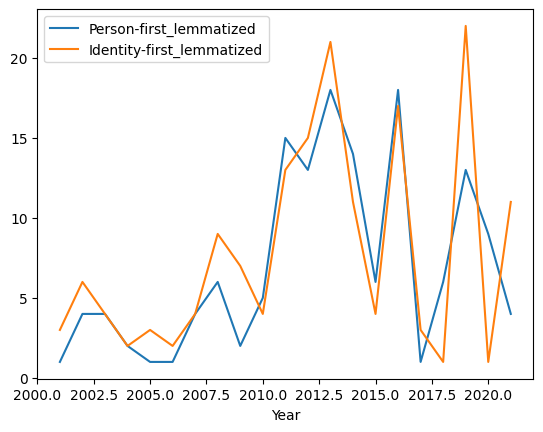

In [91]:
person_identity_count.plot()
plt.show()

In [108]:
person_examples = reviewed_matches.groupby(['Person-first_lemmatized'])['Person-first_lemmatized'].count()
identity_examples = reviewed_matches.groupby(['Identity-first_lemmatized'])['Identity-first_lemmatized'].count()
print(len(person_examples))
print(len(identity_examples))

36
39


In [109]:
person_identity_examples=pd.concat([person_examples,identity_examples],axis=1)


In [116]:
person_identity_examples.sort_values(by=['Person-first_lemmatized'], ascending=False).head(10)

,Person-first_lemmatized,Identity-first_lemmatized
patient with autism,35.0,NaN
patient with ASD,21.0,NaN
child with ASD,14.0,NaN
individual with autism,11.0,NaN
child with autism,11.0,NaN
individual with ASD,6.0,NaN
probands with ASD,5.0,NaN
boy with autism,5.0,NaN
family with ASD,3.0,NaN
family with autism,3.0,NaN


In [118]:
person_identity_examples.sort_values(by=['Identity-first_lemmatized'], ascending=False).head(10)

,Person-first_lemmatized,Identity-first_lemmatized
ASD patient,NaN,30.0
autistic patient,NaN,20.0
autistic child,NaN,14.0
autistic individual,NaN,11.0
ASD case,NaN,10.0
ASD family,NaN,10.0
ASD individual,NaN,9.0
autistic group,NaN,8.0
ASD subject,NaN,8.0
autistic population,NaN,5.0


In [97]:
person_identity_examples.notnull().sum()

Person-first_lemmatized      36
Identity-first_lemmatized    39
dtype: int64

## Count abstracts by the structures they use

In [110]:
person_by_title = person_identity_first.groupby(['Title'])['Person-first'].count()
identity_by_title = person_identity_first.groupby(['Title'])['Identity-first'].count()
title = pd.concat([person_by_title,identity_by_title],axis=1)
title

,Person-first,Identity-first
Title,,
A 3 year old patient with autism and microdeletion in the KIAA0442 (AUTS2 ) gene,1,0
A c GH Array study in non syndromic (primary) autism disorder,1,0
A clinical study of patients with pericentromeric deletion and duplication within 16p11.2 p12.2,2,0
"A cross disorder dosage sensitivity map of the human genome Ryan Lewis Collins 1, Joseph T",1,0
A highly conserved program of neuronal microexons is misregulated in autistic brains,1,0
...,...,...
Using next generation sequencing to understand the genetics of autism,1,0
cADHERiN 11 as a possible candidate gene for autism,1,0
common variants in cadherin 10 gene show association with autism spectrum disorders in Finnish population,1,0


In [111]:
title.sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Whole genome sequencing reveals the mutation characteristics in Autism Spectrum Disorder,1,1
B MLPA analysis as a diagnostic test in patients withautism spectrum disorders,3,0
Detection of genomic imbalances by arraycGH in two children with syndromic autism.,1,0
"D Mitochondrial DNA in ï¬uences the susceptibility to Autism Spectrum Disorders and the severity of the clinicalphenotype Leonardo Caporali 1, Claudio Fiorini1,2, Flavia Palombo1, Flavia Baccari3, Martina Romagnoli1, Paola Visconti4, Annio Posar4, Maria Cristina Scaduto4, Elena Maestrini5, Cinzia Cameli5, Marta Viggiano5, Anna Olivieri6, Antonio Torroni6, Elena Bacchelli5, Magali Rochat7, Valerio Carelli1,2,Alessandra Maresca1 1IRCCS Istituto delle Scienze Neurologiche di Bologna, Programma di Neurogenetica, Bologna, Italy,2Department of Biomedical and Neuromotor Sciences, University of Bologna, Bologna, Italy,3IRCCS Istituto delle Scienze Neurologiche di Bologna, UOSI Epidemiologia eStatistica, Bologna, Italy, Bologna, Italy,4IRCCS Istituto delle Scienze Neurologiche di Bologna, UOSI Disturbi dello Spettro Autistico, Bologna, Italy, Bologna, Italy,5Department of Pharmacy and Biotechnology, University of Bologna, Italy, Bologna, Italy,6Depart ment of Biology and Biotechnology ""L",1,0
D Implicating genetic risk variants for circadian rhythm and sleep trait dif ï¬culties in individuals with autism spectrum disorder,5,0
...,...,...
Identifying phenotypes and exploring genetic aetiology of autism spectrum disorders : a 87 patient study.,1,0
"Identification of a novel missense mutation in HUWE1 (Xp11.2) segregating with intellectual disability in a large family, by Targeted High Throughput Sequencing.",1,0
Genetic counselling in idiopathic autism: parental knowledge and perspectivesM,1,0


In [112]:
title.sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
Prevalence of PTEN mutations in Turkish children with autism spectrum disorders and macrocephaly,7,0
M MEF2C haploinsufficiency is a recurrent finding in patients with autism spectrum disorders,5,0
D Implicating genetic risk variants for circadian rhythm and sleep trait dif ï¬culties in individuals with autism spectrum disorder,5,0
c hildren autism and mitochondrial DNA mutations,4,0
Autism s pectrum Disorders and s eizure s yndrome,4,0
...,...,...
M Array Comparative Genome Hybridization (aCGH) in children with autistic spectrum phenotype,1,0
"M Analysis of MECP2, CDKL5, and FOXG1 genes in Czech patients with Rett syndrome and Rett like features",1,0
M A Novel HCFC1 mutation associated with X Linked Intellectual Disability,1,0


In [113]:
columns = ['Person-first','Identity-first']
filter_ = (title[columns] > 0).all(axis=1)
title[filter_]
len(title[filter_])


1

In [114]:
title[filter_].sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
Whole genome sequencing reveals the mutation characteristics in Autism Spectrum Disorder,1,1


In [115]:
title[filter_].sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Whole genome sequencing reveals the mutation characteristics in Autism Spectrum Disorder,1,1
